<a href="https://colab.research.google.com/github/yuan-code/eCommerce_Product_Recommendation_System/blob/main/Part1_eCommerce_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eCommerce Product Recommendation Part 1

Instacart Online Grocery Shopping Dataset 2017 [data descriptions](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)


A well developed recommendation system will help businesses improve their shopper's experience on website and result in better customer acquisition and retention.

The goal of the recommendation system is to predict which products will be in a customer's next order based on previous orders and trending items. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.





# Contents
* Part 0: Import Data
* Part 1: Data Exploration
* Part 2: Data Quality Check
* Part 3: Construct Model Label
* Part 4: Construct Model Features
* Part 5: Save feature data to google drive

# Part 0: Import Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

aisles.csv       model_all_data.csv  order_products_prior.csv  orders.csv
departments.csv  model.png           order_products_train.csv  products.csv


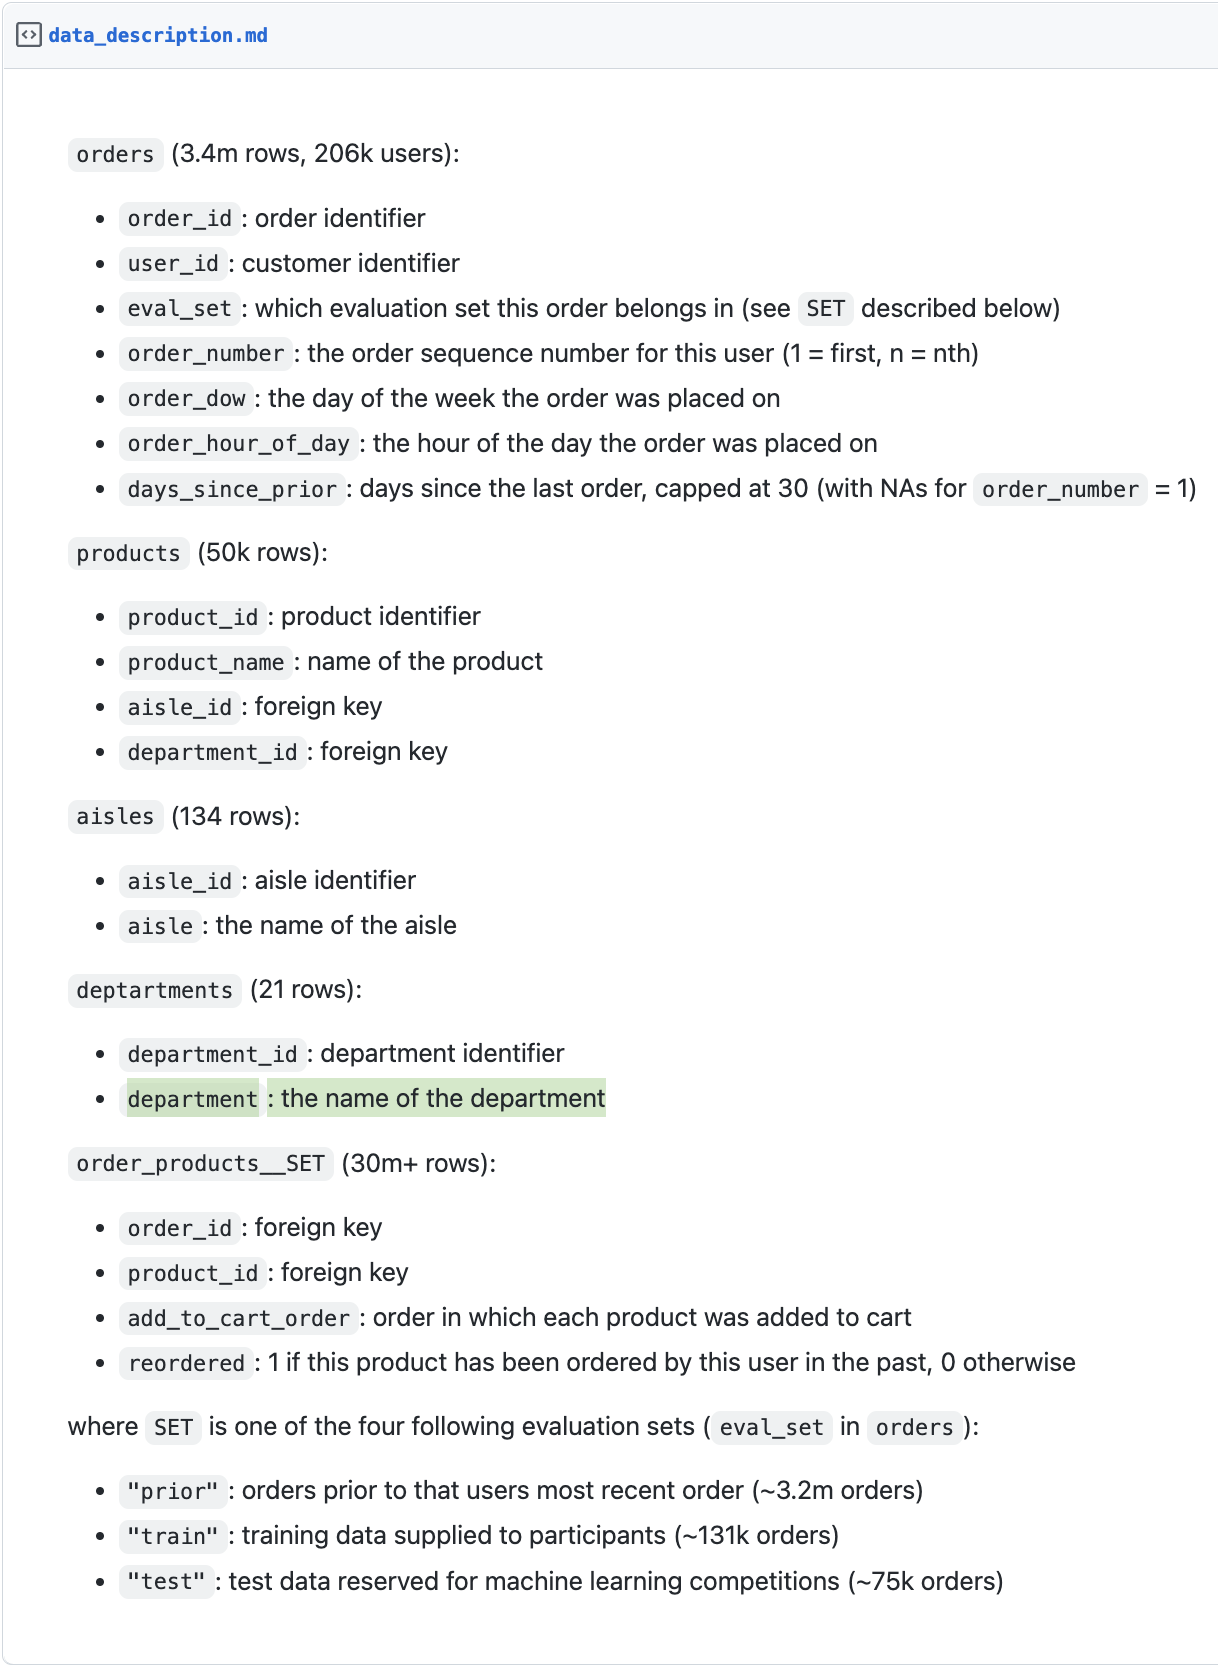

In [ ]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products_prior.csv')
order_products_train = pd.read_csv('order_products_train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [ ]:
print(aisles.shape)
print(departments.shape)
print(order_products_prior.shape)
print(order_products_train.shape)
print(orders.shape)
print(orders[orders.eval_set == 'prior'].shape)
print(orders[orders.eval_set == 'train'].shape)
print(products.shape)

(134, 2)
(21, 2)
(793924, 4)
(53704, 4)
(82683, 7)
(77683, 7)
(5000, 7)
(49688, 4)


In [ ]:
aisles.head()
# aisle_id: aisle identifier
# aisle: the name of the aisle

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments.head()
# department_id: department identifier
# department: the name of the department

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
orders.head() # Dimensional Table
# order_id: order identifier
# user_id: customer identifier
# eval_set: which evaluation set this order belongs in (see SET described below)
# order_number: the order sequence number for this user (1 = first, n = nth)
# order_dow: the day of the week the order was placed on
# order_hour_of_day: the hour of the day the order was placed on
# days_since_prior: days since the last order, capped at 30 (with NANs for order_number = 1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
products.head() # Dimensional Table
# product_id: product identifier
# product_name: name of the product
# aisle_id: foreign key
# department_id: foreign key

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
order_products_prior.head()  # Factor Table
# reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
# "prior": orders prior to that users most recent order

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [ ]:
order_products_train.head() # Factor Table
# "train": training data supplied to participants

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


# Part 1: Data Exploration

### Build order history table `prior_order_details`

In [ ]:
# Build prior order details table for data exploration
prior_order_details = order_products_prior.merge(orders, on="order_id")
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [ ]:
weekday_values = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    0: 'Sunday'
}

In [ ]:
# Covert dow to string for better visualization
prior_order_details["order_dow"] = prior_order_details["order_dow"].map(weekday_values)
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0
2,12,43772,3,1,152610,prior,22,Saturday,8,10.0
3,12,37886,4,1,152610,prior,22,Saturday,8,10.0
4,12,37215,5,0,152610,prior,22,Saturday,8,10.0


### Missing data

In [ ]:
#Finding number of customers
def get_unique_count(x):             ## Defining a function to get unique count for user_id from orders.csv
    return len(np.unique(x))

cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    5000
train    5000
Name: user_id, dtype: int64

In [ ]:
prior_order_details.isnull().any()

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool

In [ ]:
print("Size of the prior order dataset: ", prior_order_details.shape[0])
print("Missing data (NaN) count in days_since_prior_order column: ", prior_order_details[prior_order_details.days_since_prior_order.isnull()].shape[0])
print("Order_number = 1 in the prior order dataset: ", prior_order_details[prior_order_details.order_number == 1].drop_duplicates().shape[0])

Size of the prior order dataset:  793924
Missing data (NaN) count in days_since_prior_order column:  51220
Order_number = 1 in the prior order dataset:  51220


The number of lines missing days_since_prior_order in the prior order dataset is the same as the number of lines for order_number == 1. That means no missing data in the dataset.

### Order distribution

Let’s have a look when people buy groceries online.

#### Visualize weekly order frequency


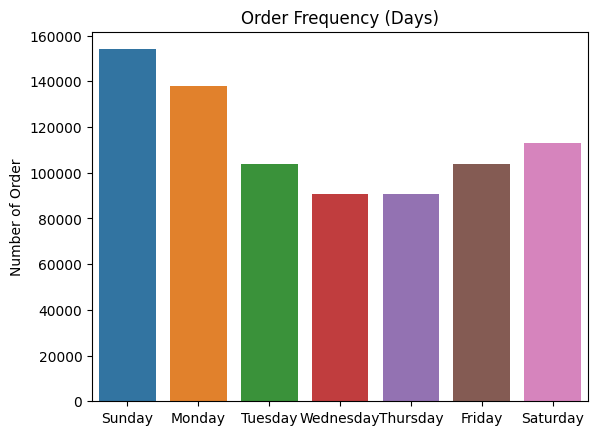

In [ ]:
#Frequency of Order Based on Days
ax = sns.countplot(x="order_dow",data=prior_order_details,
                   order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])
plt.title("Order Frequency (Days)")
plt.xlabel("")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.ylabel("Number of Order")
plt.show()

#### Visualize hourly order frequency

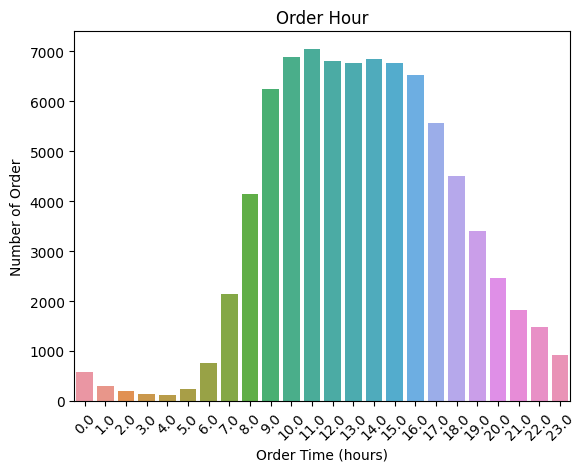

In [ ]:
order_hours_counts = orders.groupby("order_id")["order_hour_of_day"].mean().reset_index() # avoid the situation: one order has different order time.
order_hod_stats = order_hours_counts.order_hour_of_day.value_counts()
ax = sns.barplot(x=order_hod_stats.index, y=order_hod_stats.values)
plt.title("Order Hour")
plt.ylabel("Number of Order")
plt.xlabel('Order Time (hours)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

People prefer ordering online during Sunday and Monday. The number of orders is low on Wednesday and Thursday. There is a clear effect of hour of day on order volume. Most orders are done during daytime (between 8:00-18:00).

#### Validating order range by customers

It is told that the orders for customers ranging between 4 to 100 is given. Validating it below.

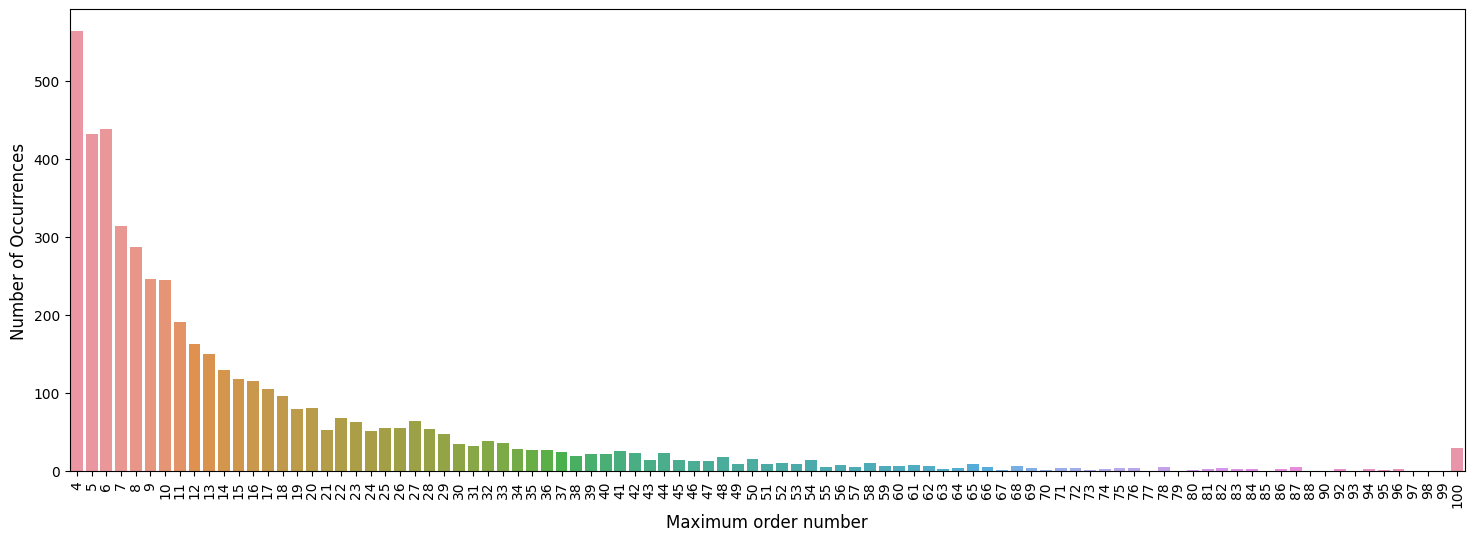

In [ ]:
order_cnt = orders.groupby("user_id").order_number.max().reset_index()
order_cnt = order_cnt.order_number.value_counts()
plt.subplots(figsize=(18, 6))
sns.barplot(x = order_cnt.index, y = order_cnt.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

There are no orders less than 4 and is max capped at 100 as given in the data page. Validated.

#### Number of products customers bought in each order

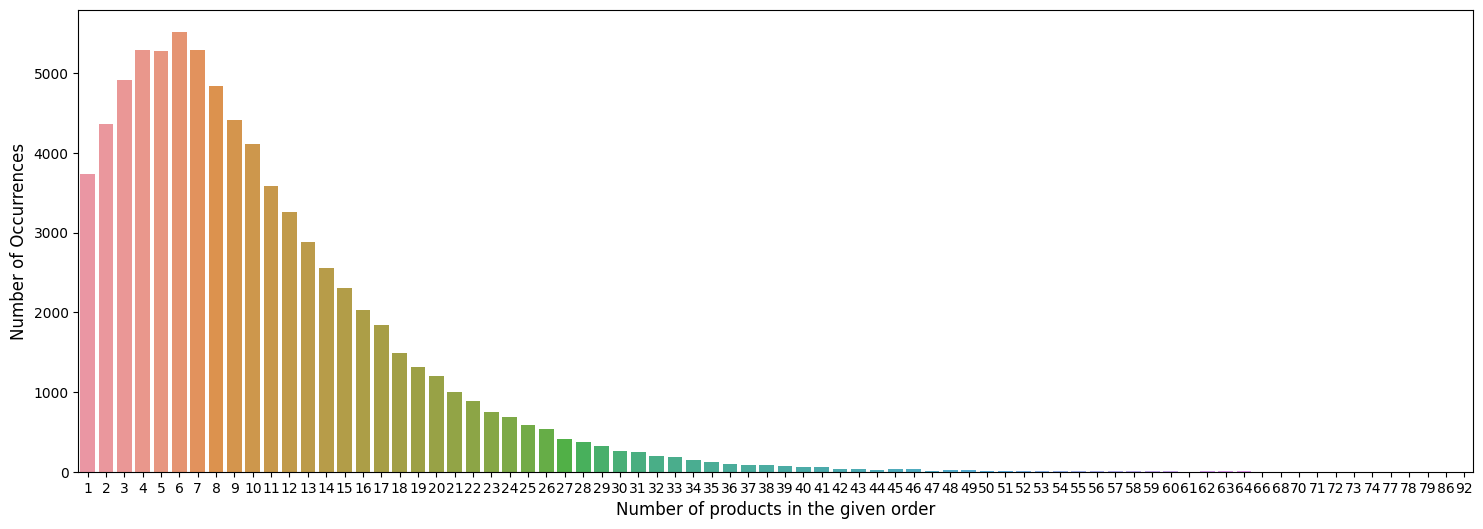

In [ ]:
items = prior_order_details.groupby("order_id").add_to_cart_order.max().reset_index()
items = items.add_to_cart_order.value_counts()
plt.subplots(figsize=(18, 6))
sns.barplot(x = items.index, y = items.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
# plt.xticks(rotation='vertical')
plt.show()

 We can see that customers most often buy around 6 items per order.

### Reorder distribution



#### Reorder frequency

When do customers order again?

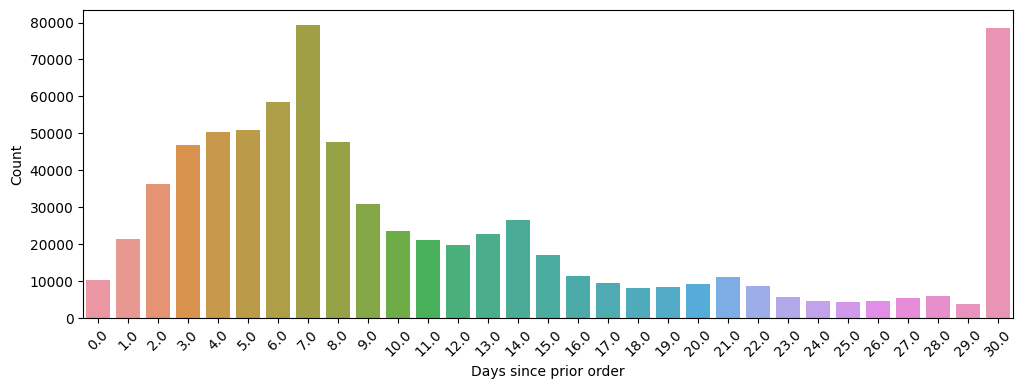

In [ ]:
# reorder_counts =
plt.figure(figsize=(12,4))
sns.countplot(x = 'days_since_prior_order', data = prior_order_details)
plt.xlabel("Days since prior order")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.show()

Looks like customers order more often after one week or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

In [ ]:
reorders = prior_order_details.groupby("reordered").reordered.count()
reorder_ratio = reorders / prior_order_details.reordered.count()
reorder_ratio.to_frame(name = 'ratios')


,ratios
reordered,
0,0.415413
1,0.584587


58% of the ordered items are reorders.

Text(0, 0.5, 'Count')

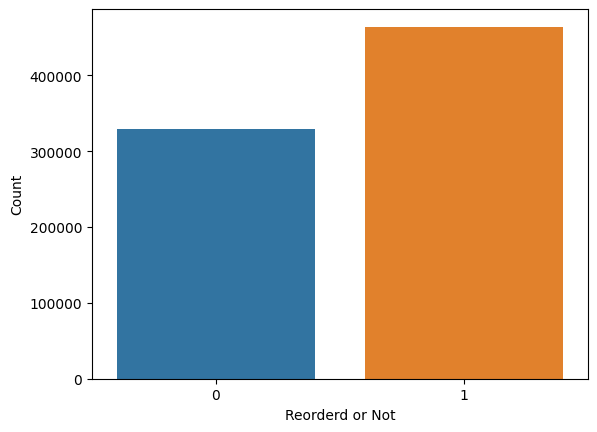

In [ ]:
sns.barplot(x = reorders.index, y = reorders.values)
plt.xlabel("Reorderd or Not")
plt.ylabel("Count")

#### Reorder Pattern Analysis (weekly order vs. hourly order)

<ipython-input-26-8430062bd2b6>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  reorder_heatmap = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')


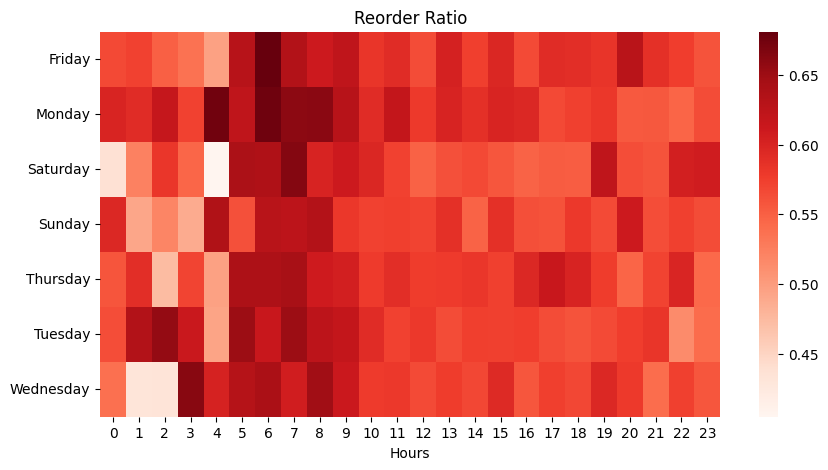

In [ ]:
reorder_heatmap = prior_order_details.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_heatmap = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')
plt.figure(figsize=(10,5))
sns.heatmap(reorder_heatmap,cmap="Reds")
plt.title("Reorder Ratio")
plt.ylabel("")
plt.xlabel("Hours")
plt.show()

### Product/Aisle/Department distribution

Let’s have a look which products are sold most often (top10).

In [ ]:
prior_product_details = prior_order_details.merge(products, on="product_id")
prior_order_all_details = prior_product_details.merge(aisles, on="aisle_id")
prior_order_all_details = prior_order_all_details.merge(departments, on="department_id")
prior_order_all_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0,French Vanilla Coffee Creamer,53,16,cream,dairy eggs
1,29292,30597,7,1,112604,prior,15,Wednesday,10,1.0,French Vanilla Coffee Creamer,53,16,cream,dairy eggs
2,50422,30597,41,0,75304,prior,28,Tuesday,8,12.0,French Vanilla Coffee Creamer,53,16,cream,dairy eggs
3,94545,30597,4,1,22499,prior,20,Thursday,9,30.0,French Vanilla Coffee Creamer,53,16,cream,dairy eggs
4,138033,30597,3,0,152610,prior,2,Thursday,13,13.0,French Vanilla Coffee Creamer,53,16,cream,dairy eggs


#### Top 10 ordered products

In [ ]:
product_counts = prior_order_all_details.product_name.value_counts().reset_index()
# product_counts = prior_order_all_details.groupby(["product_name"]).product_name.count().nlargest(5) -> Series
product_counts.columns = ["product_name", "frequency_count"]
product_counts.head(10)

,product_name,frequency_count
0,Banana,10951
1,Bag of Organic Bananas,9424
2,Organic Baby Spinach,6028
3,Organic Strawberries,6020
4,Organic Hass Avocado,5108
5,Organic Avocado,4337
6,Large Lemon,3659
7,Strawberries,3449
8,Organic Raspberries,3391
9,Limes,3329


Most of them are organic products. Also majority of them are fruits. The bestseller is Banana.



#### Top 10 reordered products

In [ ]:
reorder_counts = prior_order_all_details.groupby("product_id").reordered.agg('mean').sort_values(ascending=False).reset_index()
reorder_counts = reorder_counts.rename(columns = {'reordered':'reordered_proportion'})
# reorder_counts = pd.merge(reorder_counts, products[['product_id','product_name']], on = 'product_id')
reorder_counts = pd.merge(reorder_counts, products, on = 'product_id')
reorder_counts = pd.merge(reorder_counts, departments, on = 'department_id')
reorder_counts.head(10)
# reordered.mean().sort_values(ascending = False)

,product_id,reordered_proportion,product_name,aisle_id,department_id,department
0,10962,0.980000,Extra Strength Energy Shot,64,7,beverages
1,26111,0.969231,Classic Roast Ground Coffee,26,7,beverages
2,17469,0.968750,Lo-Carb Energy Drink,64,7,beverages
3,13128,0.950820,Purified Alkalkine Water with Minerals pH10,115,7,beverages
4,49609,0.946809,Very Berry Flavor Sparking Mineral Water,115,7,beverages
5,10598,0.944444,Yorkshire Gold Tea Bags,94,7,beverages
6,18800,0.941176,Italian Roast Coffee K-Cups,26,7,beverages
7,29938,0.939394,All Natural Lemon Tea Bottles,94,7,beverages
8,35849,0.939394,Rehab Energy Iced Tea + Pink Lemonade + Energy,64,7,beverages
9,45636,0.937500,Cranberry Pomegranate Sparkling Yerba Mate,94,7,beverages


These 10 products have the highest probability of being reordered. All are beverages.

#### Top 10 aisles

Now let us look at the important aisles.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'fresh fruits'),
  Text(1, 0, 'fresh vegetables'),
  Text(2, 0, 'packaged vegetables fruits'),
  Text(3, 0, 'yogurt'),
  Text(4, 0, 'packaged cheese'),
  Text(5, 0, 'water seltzer sparkling water'),
  Text(6, 0, 'milk'),
  Text(7, 0, 'chips pretzels'),
  Text(8, 0, 'soy lactosefree'),
  Text(9, 0, 'bread')])

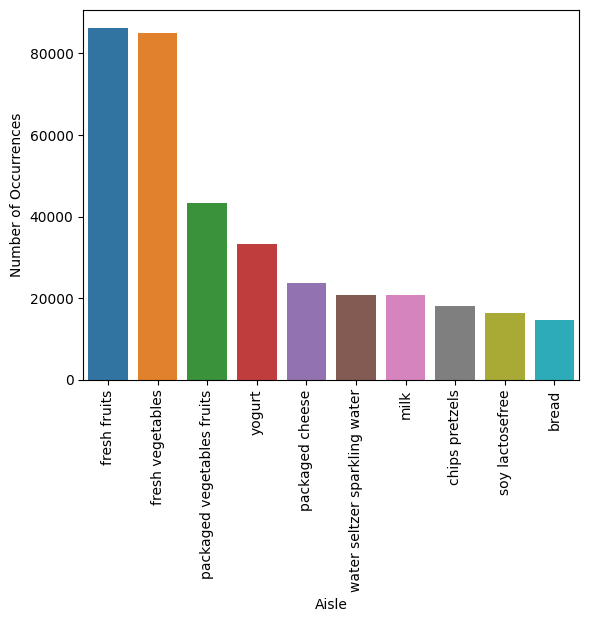

In [ ]:
aisle_counts = prior_order_all_details.aisle.value_counts().head(10)
sns.barplot(x = aisle_counts.index, y = aisle_counts.values)
plt.xlabel('Aisle')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation = 'vertical')

#### Top 10 departments

Let us now check the department wise distribution.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'produce'),
  Text(1, 0, 'dairy eggs'),
  Text(2, 0, 'snacks'),
  Text(3, 0, 'beverages'),
  Text(4, 0, 'frozen'),
  Text(5, 0, 'pantry'),
  Text(6, 0, 'bakery'),
  Text(7, 0, 'canned goods'),
  Text(8, 0, 'deli'),
  Text(9, 0, 'dry goods pasta')])

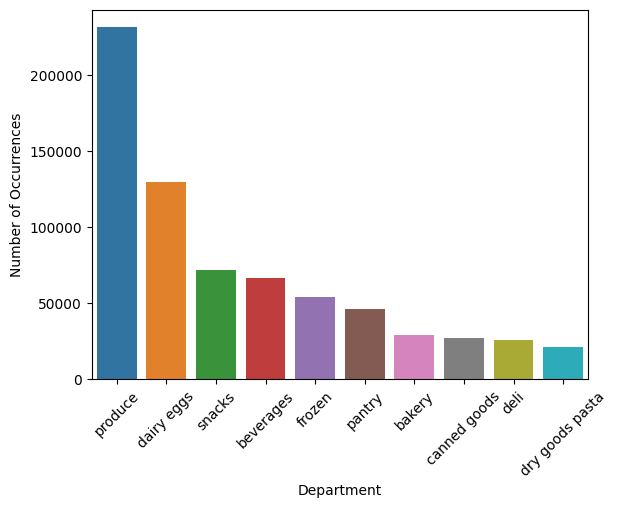

In [ ]:
department_counts = prior_order_all_details.department.value_counts().head(10)
# aisle_counts.values
sns.barplot(x = department_counts.index, y = department_counts.values)
plt.xlabel('Department')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation = 45)

# Part 2: Data Quality Check

### Validate the `days_since_prior_order` column in orders table

In [ ]:
orders.head()
# days since the last order (with NAs for order_number = 1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
print("Size of the order dataset: ", orders.shape[0])
print("Missing data (NaN) count in days_since_prior_order column: ", orders[orders.days_since_prior_order.isnull()].shape[0])
print("Order_number = 1 in order dataset: ", orders[orders.order_number == 1].drop_duplicates().shape[0])
print("user_id count in order dataset: ", orders.user_id.drop_duplicates().shape[0])

Size of the order dataset:  82683
Missing data (NaN) count in days_since_prior_order column:  5000
Order_number = 1 in order dataset:  5000
user_id count in order dataset:  5000


The number of lines missing days_since_prior_order in orders.csv is the same as the number of lines for order_number == 1, which corresponds to the number of users.

### Validate orders matching in the prior/train table

In [ ]:
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('order_id','nunique')]))

,eval_set,order_id
0,prior,77683
1,train,5000


In [ ]:
# Validate all order_id of order_products_prior.csv in orders.csv
print("order_id count in prior: ", order_products_prior.order_id.nunique())
print("order_id from prior found in orders: ", order_products_prior[order_products_prior.order_id.isin(orders.order_id)].order_id.nunique())

order_id count in prior:  77683
order_id from prior found in orders:  77683


In [ ]:
# Validate all order_id of order_products_train.csv in orders.csv
print("orders count in train: ", order_products_train.order_id.nunique())
print("order_id from train found in orders: ", order_products_train[order_products_train.order_id.isin(orders.order_id)].order_id.nunique())

orders count in train:  5000
order_id from train found in orders:  5000


### Validate the intersection between prior and train table

In [ ]:
print("order_id intersection between prior and train: ", pd.merge(order_products_prior, order_products_train, on = ['order_id']).shape[0])

order_id intersection between prior and train:  0


### Validate users matching in the prior/train table

In [ ]:
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('user_id','nunique')]))

,eval_set,user_id
0,prior,5000
1,train,5000


In [ ]:
# orders[orders.eval_set == 'prior'].user_id.nunique()
prior_user_ids = set(orders[orders.eval_set == 'prior'].user_id)
train_user_ids = set(orders[orders.eval_set == 'train'].user_id)
print("user_ids in prior: ", len(prior_user_ids))
print("user_ids in train: ", len(train_user_ids))
print("intersection of prior and train: ", len(prior_user_ids.intersection(train_user_ids)))

user_ids in prior:  5000
user_ids in train:  5000
intersection of prior and train:  5000


### Validate order counts in the train table

In [ ]:
# Validate one customer has one order in the train table
(orders[orders.user_id.isin(train_user_ids)][orders.eval_set == 'train'].groupby(['user_id']).order_number.agg('count')
.sort_values(ascending = False).reset_index().rename(columns={'order_number':'order_counts'})).head()

,user_id,order_counts
0,50,1
1,135574,1
2,135956,1
3,135881,1
4,135743,1


### Validate the relative order of `order_num` in the prior and train table

In [ ]:
df_prior_order_max = (orders[orders.user_id.isin(prior_user_ids)][orders.eval_set == 'prior'].groupby(['user_id']).order_number
  .agg('max')
  .reset_index()
  .rename(columns={'order_number':'prior_order_max'}))

In [ ]:
df_train_order_min = (orders[orders.user_id.isin(train_user_ids)][orders.eval_set == 'train'].groupby(['user_id']).order_number
  .agg('min')
  .reset_index()
  .rename(columns={'order_number':'train_order_min'}))

In [ ]:
df_order_diff = pd.merge(df_prior_order_max, df_train_order_min, on = ['user_id'])
print("Rows count where prior_order_max >= train_order_min: ",
      df_order_diff[df_order_diff.prior_order_max >= df_order_diff.train_order_min].shape[0])

Rows count where prior_order_max >= train_order_min:  0


Maximum order_num in the prior table is smaller than minimum order_num in the train table. So, we figure out that all data in the prior table are historical data.

# Part 3: Construct Model Label

**reordered**: 1 if this product has been ordered by this user in the past, 0 otherwise

- Customers who have made no or one purchases in label = 0.
- We need to find customers who have made two or more purchases in label = 1.

*We cannot use 'reordered' column as model label. The 'reordered' column tends to be imbalanced, as most products are not reordered in subsequent orders.*


The **prior dataset** contains historical order data that represents the past purchasing behavior of Instacart users. The **train dataset** represents the most recent order for each user and helps evaluate the trained model's performance on unseen data.

By using both datasets, the recommendation system aims to leverage historical user behavior as well as most recent preferences to train the models, leading to more accurate and personalized recommendations.



In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


In [ ]:
# （1）create a new column userID_productID
train_details = order_products_train.merge(orders, on = 'order_id')
train_unique_key = train_details.user_id.astype('str') + '_' + train_details.product_id.astype('str')

In [ ]:
# (2)
prior_details = order_products_prior.merge(orders, on = 'order_id')
prior_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [ ]:
#（3）
train_user_ids = set(orders[orders.eval_set == 'train']['user_id'])
model_all_data = prior_details[prior_details.user_id.isin(train_user_ids)][['user_id','product_id','order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
model_all_data = model_all_data.drop_duplicates(subset=['user_id', 'product_id']) # A customer should only have one row of data for a product.
model_all_data['unique_key'] = model_all_data['user_id'].astype('str') + '_' + model_all_data['product_id'].astype('str')
model_all_data.unique_key.duplicated().value_counts()

False    329806
Name: unique_key, dtype: int64

In [ ]:
#（4）
model_all_data['label'] = 0
model_all_data.loc[model_all_data.unique_key.isin(train_unique_key), 'label'] = 1  # userID_productID is in both prior and train datasets, label = 1
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label
0,152610,30597,22,6,8,10.0,152610_30597,0
1,152610,15221,22,6,8,10.0,152610_15221,0
2,152610,43772,22,6,8,10.0,152610_43772,0
3,152610,37886,22,6,8,10.0,152610_37886,0
4,152610,37215,22,6,8,10.0,152610_37215,0


# Part 4: Construct Model Features

We use the prior dataset alone to construct model features due to the nature of the data and the goal of capturing user preferences and behavior.

### Feature Group 1: user-product activity/interactions features

In [ ]:
user_product_features = ['user_product__total_orders', # the count of how many times the customer has purchased the product
                         'user_product__add_to_cart_order_mean', # the average order in which the customer adds the product to the cart
                         'user_product__reordered_mean', # the average reorder of the product by the customer
                         'user_product__most_dow', # the most common day of the week on which a customer purchases the product
                         'user_product__most_hod'] # the most common hour of the day on which a customer purchases the product

In [ ]:
df_user_product_features = (prior_details.groupby(['product_id','user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','count'),
                                                    ('add_to_cart_order','mean'),
                                                    ('reordered', 'mean'),
                                                    ('order_dow', (lambda x: x.mode()[0])),
                                                    ('order_hour_of_day', (lambda x: x.mode()[0])),
                                                    ])))
df_user_product_features.columns = ['product_id', 'user_id'] + user_product_features

In [ ]:
model_all_data = model_all_data.merge(df_user_product_features, on = ['user_id', 'product_id'])
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,user_product__most_hod
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,0.800,6,13
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,0.875,4,9
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,0.500,5,8
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,0.500,6,8
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,0.000,6,8


### Feature Group 2: product features

Product features are divided into two types. One is the product features summarized according to the behavior of all users, and the other is the features obtained based on the information of the product itself (attributes/characteristics).

In [ ]:
product_features = ['product__total_orders', # the count of how many times the product was purchased by all users
                     'product__add_to_cart_order_mean', # the average order in which the product is added to the cart by all users
                     'product__total_users', # the count of users who ordered the product
                     'product__reordered_mean', # how often the product is reordered by all users on average
                     'product__most_dow', # the most common day of the week on which the product was ordered
                     'product__most_hod', # the most common hour of the day on which the product was ordered
                     'product__days_since_prior_order_mean' # the average time since last purchase
                     ]

In [ ]:
df_product_features = (prior_details.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean'),
                                                    ('user_id', 'nunique'),
                                                    ('reordered', 'mean'),
                                                    ('order_dow', (lambda x: x.mode()[0])),
                                                    ('order_hour_of_day', (lambda x: x.mode()[0])),
                                                    ('days_since_prior_order', 'mean')
                                                    ])))
df_product_features.columns = ['product_id'] + product_features

In [ ]:
model_all_data = model_all_data.merge(df_product_features, on = ['product_id'])
model_all_data = model_all_data.merge(products[['product_id','aisle_id', 'department_id']],
                                      on = ['product_id'])
model_all_data.rename(columns={'aisle_id': 'product__aisle_id', 'department_id': 'product__department_id'}, inplace=True)
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,user_product__most_hod,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,product__most_dow,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.000000,...,13,85,4.2,23,0.729412,3,9,12.592593,53,16
1,112604,30597,15,3,10,1.0,112604_30597,0,5,3.800000,...,10,85,4.2,23,0.729412,3,9,12.592593,53,16
2,75304,30597,28,2,8,12.0,75304_30597,0,2,29.000000,...,8,85,4.2,23,0.729412,3,9,12.592593,53,16
3,22499,30597,20,4,9,30.0,22499_30597,1,18,2.722222,...,9,85,4.2,23,0.729412,3,9,12.592593,53,16
4,190626,30597,11,1,9,14.0,190626_30597,0,9,2.111111,...,9,85,4.2,23,0.729412,3,9,12.592593,53,16


### Feature Group 3: user features

In [ ]:
user_features = ['user__order_count', # the total number of orders for the user
                  'user__product_count', # the total number of products purchased by the user
                  'user__days_since_prior_order_mean', # average time between orders for the user
                  'user__reordered_mean', # the average reorder by the user
                  'user__most_dow', # the day of the week on which a user has placed the most orders
                  'user__most_hod', # the hour of the day on which a user has placed the most orders
                  ]

In [ ]:
df_user_features = (prior_details.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('product_id','count'),
                                                    ('days_since_prior_order','mean'),
                                                    ('reordered', 'mean'),
                                                    ('order_dow', (lambda x: x.mode()[0])),
                                                    ('order_hour_of_day', (lambda x: x.mode()[0])),
                                                    ])))
df_user_features.columns = ['user_id'] + user_features

In [ ]:
model_all_data = model_all_data.merge(df_user_features, on = ['user_id'])

In [ ]:
model_all_data['label'].value_counts()

0    297467
1     32339
Name: label, dtype: int64

In [ ]:
model_all_data.shape

(329806, 28)

# Part 5: Save feature data to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save the model_all_data dataframe as csv file to the file path we selected above.
model_all_data.to_csv('model_all_data.csv', index=False)

In [ ]:
ls

 aisles.csv               model_all_data.csv         order_products_train.csv
 departments.csv          model.png                  orders.csv
'model_all_data(1).csv'   order_products_prior.csv   products.csv
